# Chapter 19 - Metric Predicted Variable with One Nominal Predictor

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import norm
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,theano,matplotlib,seaborn,scipy

pandas    : 2.2.3
numpy     : 1.26.4
pymc3     : not installed
theano    : not installed
matplotlib: 3.10.0
seaborn   : 0.13.2
scipy     : 1.15.1



In [19]:
def gammaShRaFromModeSD(mode, sd):
    """Calculate Gamma shape and rate from mode and sd."""
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [20]:
def plot_mustache(var, sd, j, axis, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange*(width/xrange.max())
        
        # Using the negative value to flip the mustache in the right direction.
        axis.plot(-xrange_scaled+j, yrange, color=color, alpha=.6)

In [21]:
def plot_cred_lines(b0, bj, bcov, x, ax):
    """Plot credible posterior distribution lines for model in section 19.4"""
   
    B = pd.DataFrame(np.c_[b0, bj, bcov], columns=['beta0', 'betaj', 'betacov'])
    
    # Credible posterior prediction lines
    hpd_interval = pm.hpd(B.values, alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0,:]) & 
              B.betaj.between(*hpd_interval[1,:]) &
              B.betacov.between(*hpd_interval[2,:])] 
    xrange = np.linspace(x.min()*.95, x.max()*1.05)
   
    for i in np.random.randint(0, len(B_hpd), 10):
        ax.plot(xrange, B_hpd.iloc[i,0]+B_hpd.iloc[i,1]+B_hpd.iloc[i,2]*xrange, c=color, alpha=.6, zorder=0)

## 19.3 - Hierarchical Bayesian Approach

In [12]:
df = pd.read_csv(
    'C:/Users/bacos1/Documents/Python/per_python_bayes/Doing_Bayesian_Data_Analysis/data/FruitflyDataReduced.csv',
    dtype = {'CompanionNumber':'category'}
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Longevity        125 non-null    int64   
 1   CompanionNumber  125 non-null    category
 2   Thorax           125 non-null    float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 2.4 KB


In [13]:
(df
 .groupby('CompanionNumber')
 .head(2)    
)

,Longevity,CompanionNumber,Thorax
0,35,Pregnant8,0.64
1,37,Pregnant8,0.68
25,40,None0,0.64
26,37,None0,0.70
50,46,Pregnant1,0.64
51,42,Pregnant1,0.68
75,21,Virgin1,0.68
76,40,Virgin1,0.68
100,16,Virgin8,0.64
101,19,Virgin8,0.64


In [14]:
df.CompanionNumber.value_counts()

CompanionNumber
None0        25
Pregnant1    25
Pregnant8    25
Virgin1      25
Virgin8      25
Name: count, dtype: int64

### Model

In [37]:
x = df.CompanionNumber.cat.codes.values
y = df.Longevity

In [38]:
yMean = y.mean()
ySD = y.std()

In [39]:
NxLvl = len(df.CompanionNumber.cat.categories)

In [40]:
agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

In [43]:
with pm.Model() as model1:

    # Priors
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    likelihood = pm.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', pt.mean(m))
    b = pm.Deterministic('b', m - b0) 

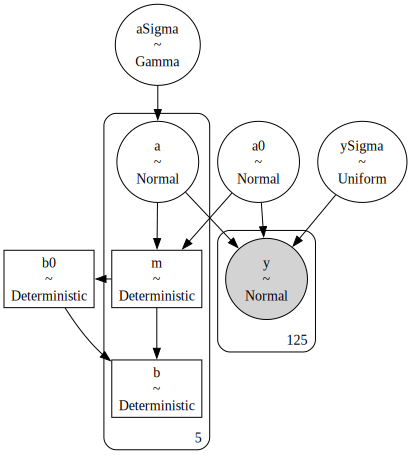

In [44]:
pm.model_to_graphviz(model1)

In [45]:
with model1:
    trace1 = pm.sample(3000, cores=4, nuts_kwargs={'target_accept': 0.95})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aSigma, a0, a, ySigma]


Sampling 4 chains, 0 divergences ----------------------- 100% 0:00:00 / 0:00:0800:0800:07


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 39 seconds.


In [46]:
with model1:
    trace1 = pm.sample(
        draws = 10000,
        tune = 1000,
        chains = 4,
        nuts_sampler="numpyro",
        nuts_sampler_kwargs = {'chain_method':'vectorized'},
        progressbar=True,
        random_seed = 123456
    )

sample: 100%|██████████| 11000/11000 [00:26<00:00, 411.91it/s]


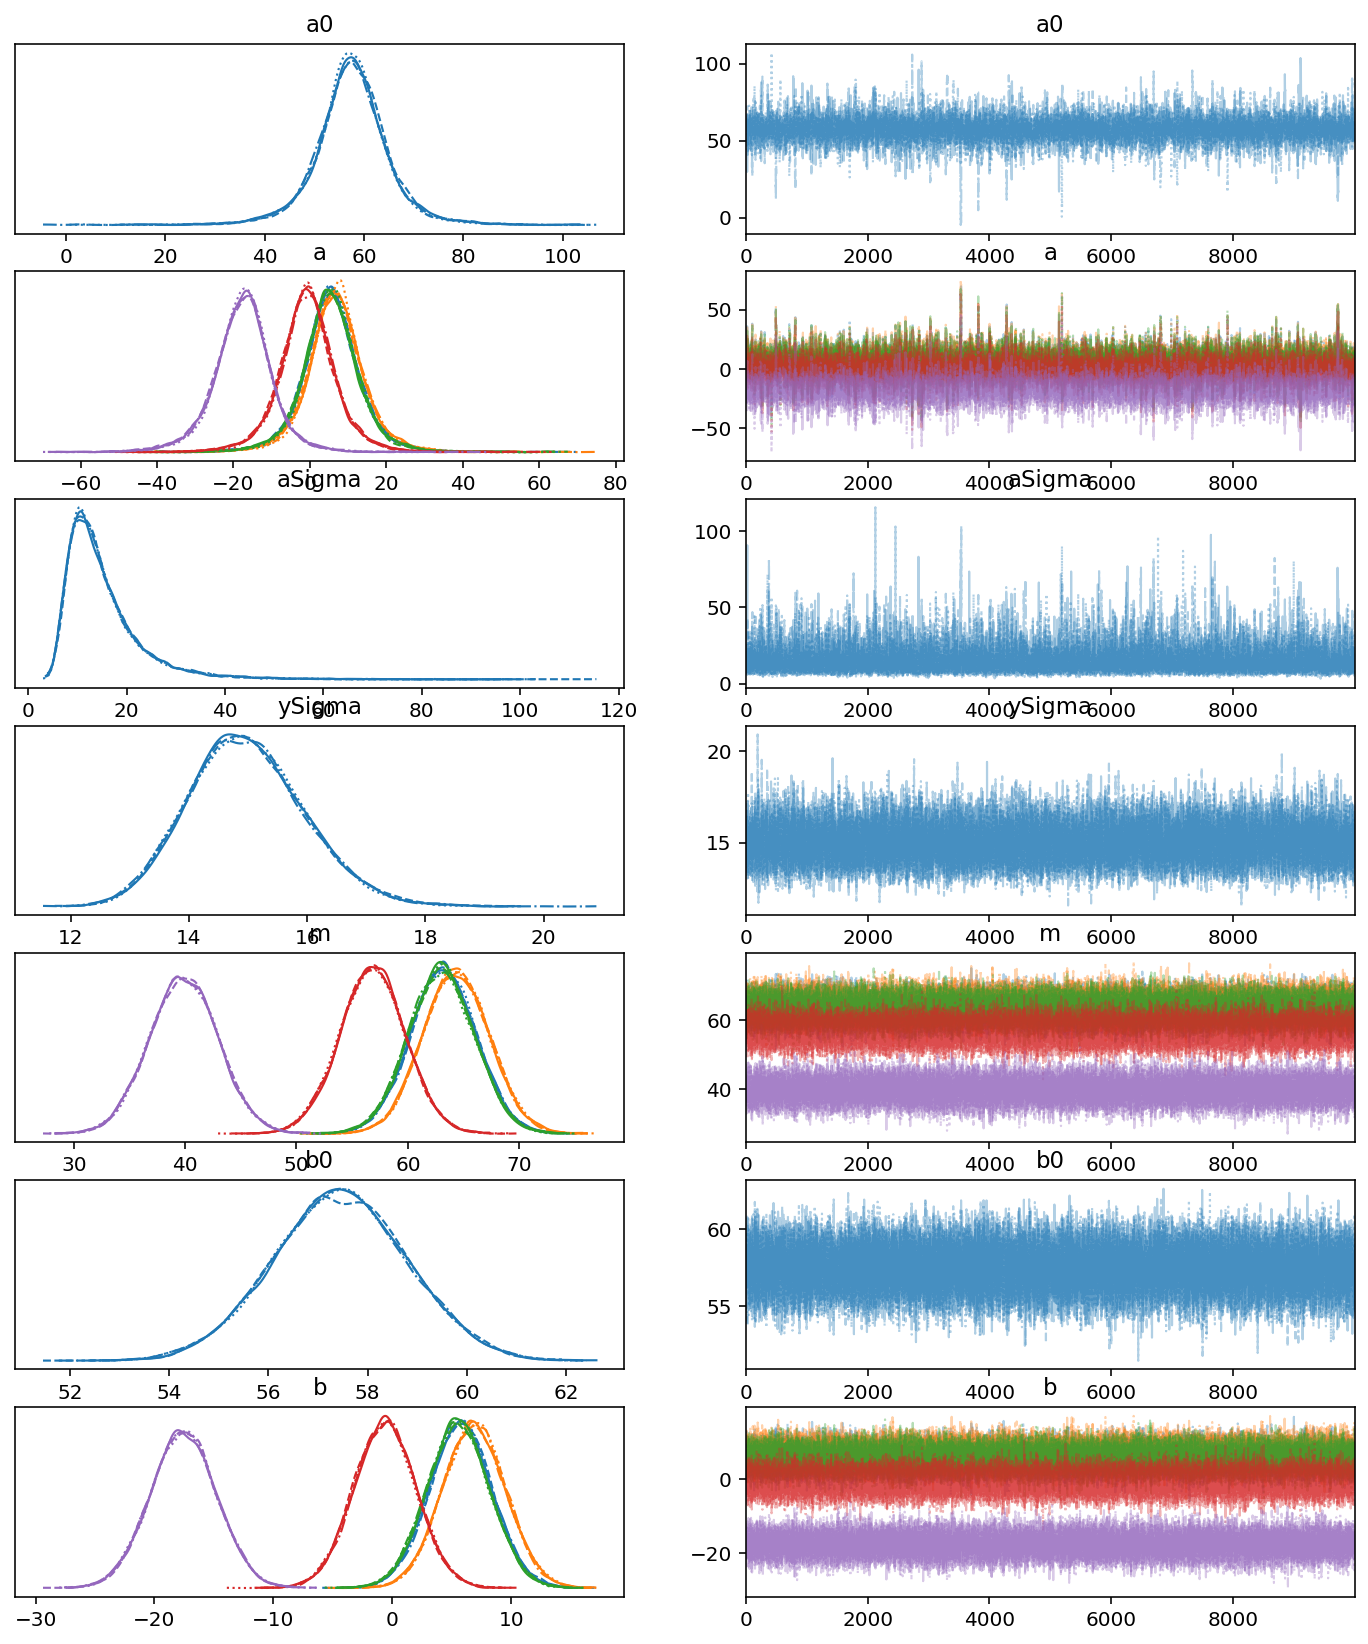

In [49]:
az.plot_trace(trace1);

In [50]:
# Here we plot the metric predicted variable for each group. Then we superimpose the 
# posterior predictive distribution

None0 = trace1['m'][:,0]
Pregnant1 = trace1['m'][:,1]
Pregnant8 = trace1['m'][:,2]
Virgin1 = trace1['m'][:,3]
Virgin8 = trace1['m'][:,4]
scale = trace1['ySigma'][:]

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.set_title('Data with Posterior Predictive Distribution')

sns.swarmplot('CompanionNumber', 'Longevity', data=df, ax=ax);
ax.set_xlim(xmin=-1)

for i, grp in enumerate([None0, Pregnant1, Pregnant8, Virgin1, Virgin8]):
    plot_mustache(grp, scale, i, ax)

KeyError: 'm'